In [1]:
# Preview where Python thinks you are
import os
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_results_analysis


In [1]:
from pathlib import Path

# Automatically get the base path of your project
base_path = Path.cwd().parents[0]  # adjust .parents[0] if needed
print("Base path of the project:", base_path)

Base path of the project: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db


In [3]:
# This code is more robust and will work regardless of the current working directory.
# Make sure that base_path is defined correctly.
# Install the requirements from the requirements.txt file
#!pip3 install -r "{base_path}/requirements.txt"

In [ ]:
# Make sure to install ete3 if it's not already installed
!pip3 install ete3

We are going to load the metagenomics dataset with lca annotations (this includes all the proteins in the database before performing PSM's) and this time we don't only visualize the taxa from the psm data as we did with the custom databases because we want to see all the possible organisms that could be included in the ideal metagenomics database so that we know what organisms we might miss in any of the databases we constructed. 

## Step 1: Load the Annotated Metagenomics Protein Table

Before we begin analyzing peptide-spectrum matches (PSMs), we load the metagenomics dataset containing pre-annotated protein-level taxonomic information. This dataset represents the theoretical protein database derived from metagenomic sequencing of the same sample. It includes the **protein ID**, its corresponding **LCA (Lowest Common Ancestor) taxon ID**, and **protein alignment score**.  

By loading this file, we gain insight into all possible taxa that could be detected from this metagenomic sample—regardless of whether they were matched in the actual PSM search. This makes it useful for comparing the taxonomic coverage **before** PSM filtering (ideal case) vs **after** PSM filtering (experimental results).


In [2]:
# Paste the path to the file containing the metagenomic annotations with lca's here
metagenraw_path = r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_psm_results\protein_alignment\GW_nr_bitlca.csv"

In [3]:
import pandas as pd
from pathlib import Path

# === Load CSV ===
# Explicitly name the columns since no header is present in the file
df_meta = pd.read_csv(metagenraw_path, header=None, names=["protein_id", "lca_taxid", "score"])

# === Show first 15 rows ===
print("First 15 rows of the annotated DataFrame:")
print(df_meta.head(15))


First 15 rows of the annotated DataFrame:
                                protein_id  lca_taxid  score
0    NODE_1_length_1846635_cov_14.991676_1    2035772   99.4
1    NODE_1_length_1846635_cov_14.991676_2    2026735  159.0
2    NODE_1_length_1846635_cov_14.991676_3          2  318.0
3    NODE_1_length_1846635_cov_14.991676_4         29  335.0
4    NODE_1_length_1846635_cov_14.991676_5    2026735  260.0
5    NODE_1_length_1846635_cov_14.991676_6    2026735  287.0
6    NODE_1_length_1846635_cov_14.991676_7      28221  129.0
7    NODE_1_length_1846635_cov_14.991676_8    1869227  302.0
8    NODE_1_length_1846635_cov_14.991676_9    2026735  407.0
9   NODE_1_length_1846635_cov_14.991676_10    2026735  372.0
10  NODE_1_length_1846635_cov_14.991676_11    1978231   67.8
11  NODE_1_length_1846635_cov_14.991676_13    1962667  281.0
12  NODE_1_length_1846635_cov_14.991676_14      28221  245.0
13  NODE_1_length_1846635_cov_14.991676_15      28221   84.7
14  NODE_1_length_1846635_cov_14.991676_16 

## Step 2: Map LCA Taxon IDs to Scientific Names

The metagenomics dataset includes taxonomic annotations in the form of **NCBI Taxonomy IDs (taxid)**. While these are useful for computational purposes, they are not human-readable.

In this step, we use the `ete3` Python library and its `NCBITaxa` interface to map each unique `lca_taxid` in the dataset to its corresponding scientific name (e.g., *Nitrospira defluvii*). This will allow us to generate readable composition plots and summaries later in the pipeline.

Note: The first time this code is run, `ete3` will download a local NCBI taxonomy database (~400MB). Make sure you have internet access and write permissions in your environment.


In [4]:
from ete3 import NCBITaxa
import pandas as pd
from pathlib import Path
from IPython.display import display

# === Step 2a: Initialize the NCBI Taxonomy interface ===
# This will download or access a local SQLite taxonomy database
ncbi = NCBITaxa()

# === Step 2b: Extract unique taxon IDs from previous dataframe ===
# These taxon IDs are the LCA results from the metagenomic annotation step
unique_taxids = df_meta["lca_taxid"].unique()

# === Step 2c: Translate taxon IDs to scientific names ===
# Returns a dictionary {taxid: "scientific name"} using local NCBI database
taxid_to_name = ncbi.get_taxid_translator(unique_taxids)

# === Step 2d: Add taxon names to the original DataFrame ===
df_meta_names = df_meta.copy()
df_meta_names["taxon_name"] = df_meta_names["lca_taxid"].map(taxid_to_name)

# === Step 2e: Show preview of annotated DataFrame ===
display(df_meta_names.shape)  # Shape of the full annotated DataFrame
print("📋 Annotated DataFrame with taxon names:")
display(df_meta_names.head(15))


(1505129, 4)

📋 Annotated DataFrame with taxon names:


,protein_id,lca_taxid,score,taxon_name
0,NODE_1_length_1846635_cov_14.991676_1,2035772,99.4,Candidatus Omnitrophota bacterium
1,NODE_1_length_1846635_cov_14.991676_2,2026735,159.0,Deltaproteobacteria bacterium
2,NODE_1_length_1846635_cov_14.991676_3,2,318.0,Bacteria
3,NODE_1_length_1846635_cov_14.991676_4,29,335.0,Myxococcales
4,NODE_1_length_1846635_cov_14.991676_5,2026735,260.0,Deltaproteobacteria bacterium
5,NODE_1_length_1846635_cov_14.991676_6,2026735,287.0,Deltaproteobacteria bacterium
6,NODE_1_length_1846635_cov_14.991676_7,28221,129.0,Deltaproteobacteria
7,NODE_1_length_1846635_cov_14.991676_8,1869227,302.0,bacterium
8,NODE_1_length_1846635_cov_14.991676_9,2026735,407.0,Deltaproteobacteria bacterium
9,NODE_1_length_1846635_cov_14.991676_10,2026735,372.0,Deltaproteobacteria bacterium


## Step 3: Annotate Each LCA Taxon ID with Its Rank

In this step, we retrieve the **taxonomic rank** (e.g., *species*, *genus*, *family*) associated with each LCA taxon ID in the metagenomics dataset. This allows us to group and analyze taxonomic composition at different levels of resolution.

We use the `NCBITaxa` class from the `ete3` library to perform this mapping. The taxonomic rank is essential for generating rank-specific community composition plots later on in the pipeline.


In [5]:
from ete3 import NCBITaxa

# === Step 3a: Initialize NCBI taxonomy database ===
# The first call sets up or connects to the local cached taxonomy database.
ncbi = NCBITaxa()

# === Step 3b: Extract all unique LCA taxon IDs from the annotated DataFrame ===
# These are the same taxon IDs we used to derive scientific names earlier.
unique_taxids = df_meta_names["lca_taxid"].unique()

# === Step 3c: Get the taxonomic rank for each taxon ID ===
# Returns a dictionary {taxid: "rank"} using the local taxonomy database
taxid_to_rank = ncbi.get_rank(unique_taxids)

# === Step 3d: Create a copy of the DataFrame and add the 'rank' column ===
df_meta_ranks = df_meta_names.copy()
df_meta_ranks["taxon_rank"] = df_meta_ranks["lca_taxid"].map(taxid_to_rank)

# === Step 3e: Preview the updated DataFrame ===
# You can verify that the 'rank' column is now included and correctly mapped.
display(df_meta_ranks.shape)
display(df_meta_ranks.head(15))


(1505129, 5)

,protein_id,lca_taxid,score,taxon_name,taxon_rank
0,NODE_1_length_1846635_cov_14.991676_1,2035772,99.4,Candidatus Omnitrophota bacterium,species
1,NODE_1_length_1846635_cov_14.991676_2,2026735,159.0,Deltaproteobacteria bacterium,species
2,NODE_1_length_1846635_cov_14.991676_3,2,318.0,Bacteria,domain
3,NODE_1_length_1846635_cov_14.991676_4,29,335.0,Myxococcales,order
4,NODE_1_length_1846635_cov_14.991676_5,2026735,260.0,Deltaproteobacteria bacterium,species
5,NODE_1_length_1846635_cov_14.991676_6,2026735,287.0,Deltaproteobacteria bacterium,species
6,NODE_1_length_1846635_cov_14.991676_7,28221,129.0,Deltaproteobacteria,class
7,NODE_1_length_1846635_cov_14.991676_8,1869227,302.0,bacterium,species
8,NODE_1_length_1846635_cov_14.991676_9,2026735,407.0,Deltaproteobacteria bacterium,species
9,NODE_1_length_1846635_cov_14.991676_10,2026735,372.0,Deltaproteobacteria bacterium,species


## Save Taxa-Annotated Metagenomics DataFrame for Reuse

Although this step is not part of the core analysis pipeline, it is highly recommended to persist the annotated DataFrame containing taxon names and ranks. 

By saving it to disk, we avoid having to repeat the expensive steps of taxon ID mapping and rank fetching in future analyses. This also allows the annotated file to be imported and visualized in separate notebooks, for instance when comparing metagenomics-derived communities with custom databases at various rank levels.


In [ ]:
# === Define the output path ===
# This is where we will store the annotated DataFrame for later reuse.
output_path = Path("../Community_comparisons/metagenomics_taxa_annotated.csv")

# === Create the directory if it doesn't exist ===
# Ensures the parent directory structure exists before saving.
output_path.parent.mkdir(parents=True, exist_ok=True)

# === Save the DataFrame to CSV ===
# The file includes peptide-level LCA taxon names and rank annotations.
df_meta_ranks.to_csv(output_path, index=False)

# === Confirmation message ===
print(f"Saved to: {output_path.resolve()}")


Saved to: C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\Community_comparisons\metagenomics_taxa_annotated.csv


In [ ]:
# Display how many proteins are annotated at each rank
rank_counts = df_meta_ranks["taxon_rank"].value_counts().sort_values(ascending=False)

# Print the summary
print("Number of proteins annotated at each taxonomic rank:")
print(rank_counts)

📊 Number of proteins annotated at each taxonomic rank:
rank
species           956227
order             115458
family            112710
class             108594
genus              92495
phylum             88807
domain             30561
acellular root        22
strain                14
subspecies             7
no rank                4
clade                  1
Name: count, dtype: int64


## Visualize Community Composition at Different Taxonomic Ranks

To better understand the taxonomic resolution offered by the metagenomics database, we plot the microbial community composition at multiple levels: **strain**, **species**, **genus**, and **family**.

The relative abundance is calculated based on the number of PSMs (peptide-spectrum matches) assigned to each taxon at the selected rank. For each rank, the top-N most abundant taxa are shown in a horizontal bar chart. This helps identify which organisms dominate the sample and how resolution changes across rank levels.

The `df_meta_ranks` input contains the peptide-wise taxon assignments, derived from the LCA taxonomy and enriched with both taxon names and rank information using the NCBI Taxonomy database.


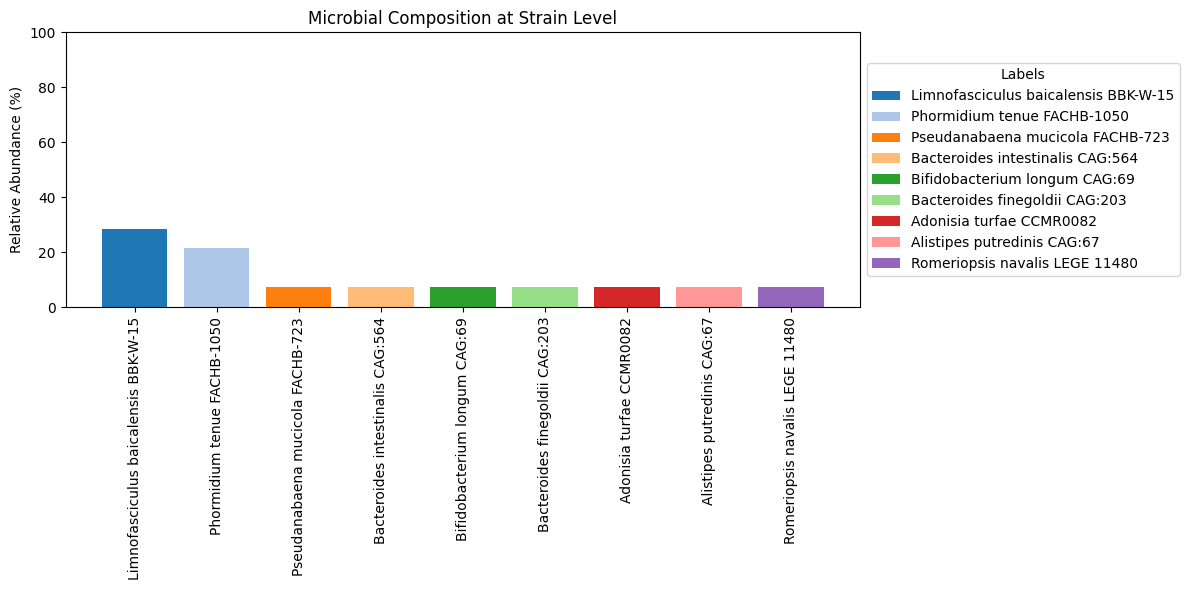

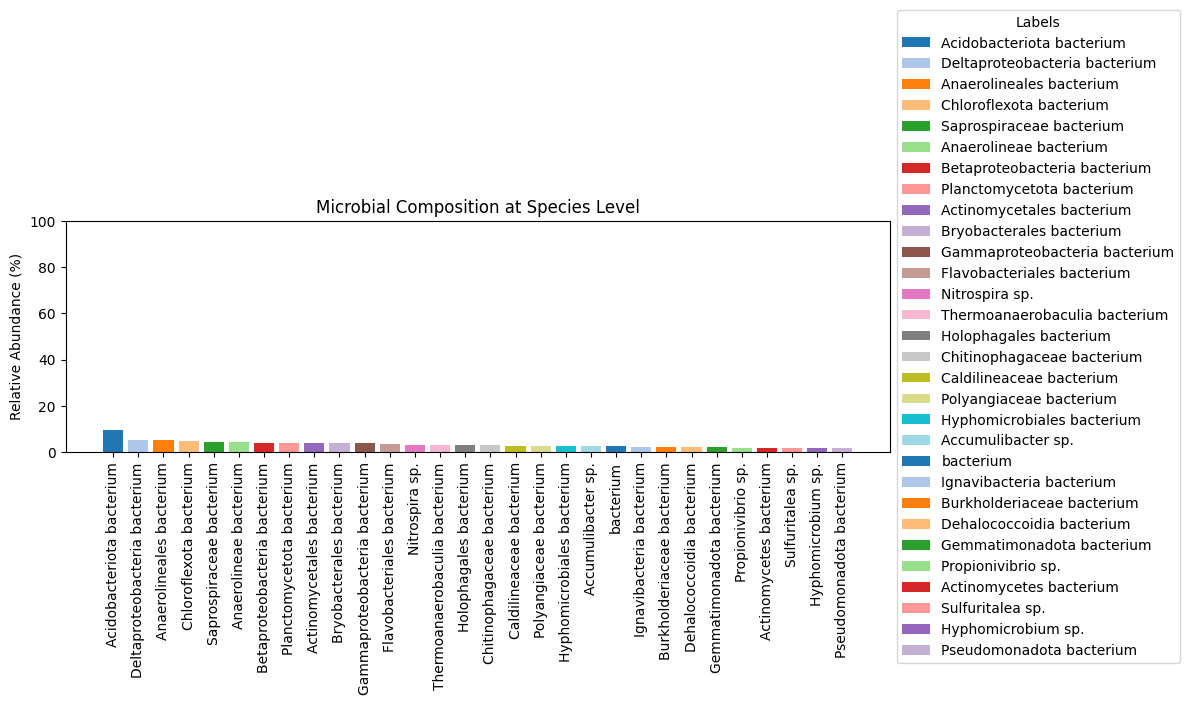

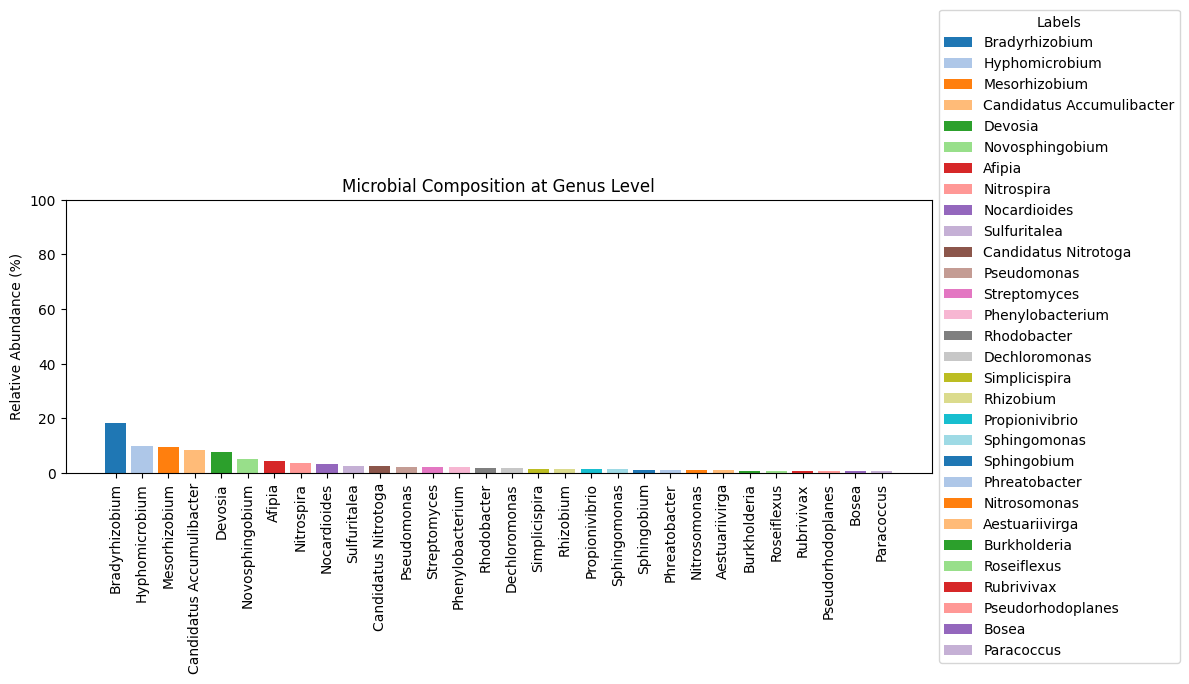

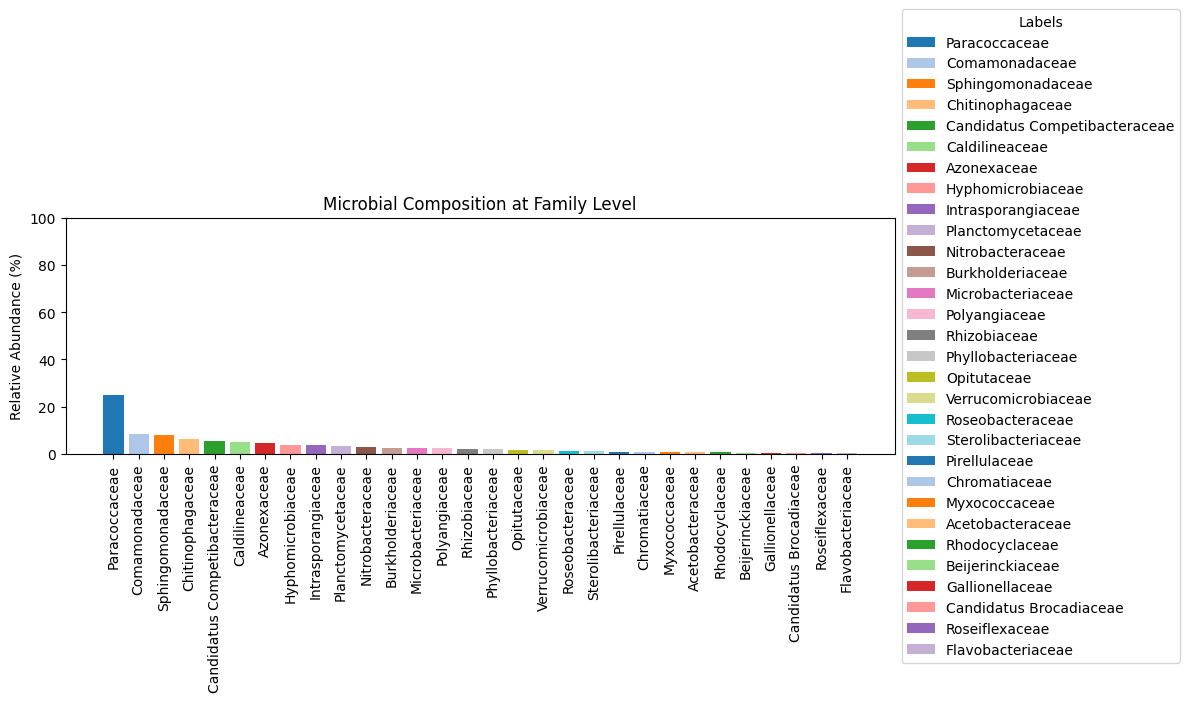

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colormaps
from IPython.display import display

# === Define plot function for a single taxonomic rank ===
def plot_microbial_composition(df, rank_level, top_n=30):
    # Filter only entries at the specified rank (e.g., genus, species, etc.)
    df_filtered = df[df["taxon_rank"] == rank_level]

    # Skip plot if no entries found at this rank
    if df_filtered.empty:
        print(f"No entries found at rank: {rank_level}")
        return

    # Count occurrences of each taxon and convert to relative abundance
    taxon_counts = df_filtered["taxon_name"].value_counts().head(top_n)
    relative_abundance = (taxon_counts / taxon_counts.sum()) * 100
    taxa = relative_abundance.index.tolist()

    # Generate unique colors using matplotlib's colormap system
    cmap = colormaps.get_cmap("tab20")
    colors = [cmap(i % cmap.N) for i in range(len(taxa))]

    # === Create the bar chart ===
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(taxa))
    bars = ax.bar(x, relative_abundance.values, color=colors)

    # Format x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(taxa, rotation=90, ha="center")

    # Set y-axis and title
    ax.set_ylabel("Relative Abundance (%)")
    ax.set_title(f"Microbial Composition at {rank_level.capitalize()} Level")
    ax.set_ylim(0, 100)

    # Add legend outside the plot
    ax.legend(bars, taxa, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# === Generate plots for multiple taxonomic ranks ===
for level in ["strain", "species", "genus", "family"]:
    plot_microbial_composition(df_meta_ranks, level)


Now that we plotted the microbial composition at four rank levels for the metagenomics database before psm, now we want to plot it for the psm's of the metagenomics database (i.e. after testing the database on theoretical spectra) while taking into account the areas of the psm's.

## Load Metagenomics PSM Results (After Spectrum Matching)

Now that we've visualized the microbial community composition **before PSM**, based on the theoretical protein entries in the metagenomics database, we shift our focus to the **observed peptides** after performing **PSM (Peptide-Spectrum Match)** analysis using PEAKS Studio.

The goal here is to analyze the taxonomic distribution of these observed peptides and compare it to the expected profile (from the full database), allowing us to understand what portion of the theoretical community is actually detected in the experiment.

This first code block loads the exported PSM results from PEAKS (after matching the raw spectra against the metagenomics database), previews the shape of the dataset, and shows the first few rows. The dataset will later be annotated and used for taxonomic composition analysis at different rank levels.


In [ ]:
# Paste the path to your MetagenPSM results file between the quotes
metagenpsm_path = r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_psm_results\Peaks_export\YA_RZ_GW_SHMX_DB_analysis_GW_MG_DB_clean\DB search psm metagenomics.csv"

In [ ]:
import pandas as pd

# === Step 1: Define the path to your PEAKS PSM result file ===
# This is the output of searching the metagenomics protein database against the actual experimental spectra.
metagenpsm_path = r"C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_psm_results\Peaks_export\YA_RZ_GW_SHMX_DB_analysis_GW_MG_DB_clean\DB search psm metagenomics.csv"

# === Step 2: Load the PSM result CSV into a DataFrame ===
# This file contains all identified peptide-spectrum matches (PSMs) with associated metadata
df_psm = pd.read_csv(metagenpsm_path)

# === Step 3: Display basic info ===
# Display the shape of the DataFrame to get an idea of the number of PSMs (rows) and columns
display(df_psm.shape)

# Show the first few rows to inspect the structure and column names
display(df_psm.head())

# The output shows 15,049 PSMs with 18 columns including:
# - 'Peptide': the sequence identified
# - '-10lgP': confidence score (used later for filtering)
# - 'Area': intensity/quantitation value associated with the peptide
# - 'Source File': used to trace the matched protein back to its origin in the metagenomics FASTA DB

(15049, 18)

,Peptide,-10lgP,Mass,Length,ppm,m/z,Z,RT,Area,Fraction,Id,Scan,from Chimera,Source File,Accession,PTM,AScore,Found By
0,TPTTDGTQNDSAYDFSAAVHSAR,148.86,2411.0625,23,-1.2,804.6938,3,99.95,110500000.0,1,40532,32903,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,NODE_514_length_56624_cov_10.429334_2,NaN,NaN,PEAKS DB
1,TPTTDGTQNDSAYDFSAAVHSAR,141.51,2411.0625,23,-1.2,804.6938,3,99.95,110500000.0,1,40533,33198,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,NODE_514_length_56624_cov_10.429334_2,NaN,NaN,PEAKS DB
2,TPTTDGTQNDSAYDFSAAVHSAR,121.60,2411.0625,23,-1.2,804.6938,3,99.95,110500000.0,1,40534,33478,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,NODE_514_length_56624_cov_10.429334_2,NaN,NaN,PEAKS DB
3,TPTTDGTQNDSAYDFSAAVHSAR,120.23,2411.0625,23,1.5,1206.5403,2,99.92,1075000.0,1,40508,32757,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,NODE_514_length_56624_cov_10.429334_2,NaN,NaN,PEAKS DB
4,TPTTDGTQNDSAYDFSAAVHSAR,120.16,2411.0625,23,-0.1,804.6947,3,102.14,0.0,1,78090,33762,No,MP_RZ07032023_GW_flat_180min_DDA02.raw,NODE_514_length_56624_cov_10.429334_2,NaN,NaN,PEAKS DB


## PSM Summary Statistics and Peptide Distribution

Once the PSM results from the metagenomics database have been loaded, it's important to extract a few key metrics to assess the scale and depth of the search results.

This code block performs basic exploratory analysis by calculating:
- The total number of PSMs (rows in the dataset).
- The number of unique peptide sequences identified.
- How many unique peptides map to each protein (Accession), giving insight into coverage.

These summaries help you understand:
- Whether there is significant redundancy (many PSMs from the same peptide),
- Whether certain proteins dominate the identifications,
- And how well-represented individual protein entries are in terms of peptide support.


In [ ]:
# === Basic peptide count metrics ===

# Total number of peptide-spectrum matches (PSMs) observed
total_psms = len(df_psm)

# Count of unique peptide sequences — helps assess sequence diversity in the sample
unique_peptides = df_psm["Peptide"].nunique()

# Print summary stats
print(f"Total PSMs: {total_psms}")
print(f"Unique peptides: {unique_peptides}")

# === Optional: peptide counts per protein accession ===

# Group the data by protein accession and count how many *unique* peptides were matched to each protein.
# This helps to understand which proteins are highly represented in terms of distinct peptide support.
peptides_per_protein = df_psm.groupby("Accession")["Peptide"].nunique().sort_values(ascending=False)

# Display the top 10 most peptide-rich proteins
print("\n📦 Peptide counts per protein (top 10):")
print(peptides_per_protein.head(10))



🔢 Total PSMs: 15049
🧬 Unique peptides: 10265

📦 Peptide counts per protein (top 10):
Accession
NODE_28686_length_3771_cov_2.843649_3      61
NODE_864_length_43498_cov_10.271850_1      42
NODE_514_length_56624_cov_10.429334_2      41
NODE_1816_length_28045_cov_24.963737_2     36
NODE_24640_length_4187_cov_21.225557_1     33
NODE_33213_length_3431_cov_8.757109_1      32
NODE_28686_length_3771_cov_2.843649_2      31
NODE_57_length_140165_cov_37.325423_74     30
NODE_30903_length_3596_cov_24.096865_1     30
NODE_4264_length_15603_cov_27.157062_12    30
Name: Peptide, dtype: int64


## Mapping PSMs to Taxonomic Information

Now that we have both:
- the PSM search results (containing peptide matches and their corresponding protein accessions), and
- a pre-annotated metagenomics database with LCA taxonomic assignments per protein,

we can join these datasets to transfer taxonomic annotations (e.g. `lca_taxid`) to each PSM. This is a critical step because we want to analyze the community composition *after* database search — not just based on theoretical proteins, but on the actual spectral matches.

We do this by matching the `"Accession"` column from the PSM data to the `"protein_id"` column in the annotated database, which links each protein to its `lca_taxid`.

This results in a merged DataFrame where each PSM is enriched with taxonomic metadata.


In [ ]:
# === Merge PSM results with annotated metagenomics database ===
# We join on: PSM's "Accession" <-> annotated DB's "protein_id"
df_psm_with_taxa = pd.merge(
    df_psm,  # the PSM results DataFrame
    df_meta_ranks[["protein_id", "lca_taxid"]],  # select only columns needed from the annotated DB
    left_on="Accession",   # match PSM's accession column
    right_on="protein_id", # match DB protein ID column
    how="left"  # keep all PSMs even if some proteins weren't found in the annotation
)

# === Optional cleanup: remove redundant column from the right table ===
df_psm_with_taxa.drop(columns=["protein_id"], inplace=True)

# === Preview ===
# Use IPython display for prettier rendering
from IPython.display import display

# Show the shape to confirm number of PSMs and columns
display(df_psm_with_taxa.shape)

# Show a preview of the columns we care about most for downstream taxonomic work
display(df_psm_with_taxa[["Peptide", "Area", "Accession", "lca_taxid"]].head(15))

(15049, 19)

,Peptide,Area,Accession,lca_taxid
0,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,NODE_514_length_56624_cov_10.429334_2,1898103.0
1,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,NODE_514_length_56624_cov_10.429334_2,1898103.0
2,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,NODE_514_length_56624_cov_10.429334_2,1898103.0
3,TPTTDGTQNDSAYDFSAAVHSAR,1075000.0,NODE_514_length_56624_cov_10.429334_2,1898103.0
4,TPTTDGTQNDSAYDFSAAVHSAR,0.0,NODE_514_length_56624_cov_10.429334_2,1898103.0
5,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,NODE_514_length_56624_cov_10.429334_2,1898103.0
6,TPTTDGTQNDSAYDFSAAVHSAR,11542.0,NODE_514_length_56624_cov_10.429334_2,1898103.0
7,TPTTDGTQNDSAYDFSAAVHSAR,697490.0,NODE_514_length_56624_cov_10.429334_2,1898103.0
8,TPTTDGTQNDSAYDFSAAVHSAR,21007.0,NODE_514_length_56624_cov_10.429334_2,1898103.0
9,LAGPASEGVVC(+57.02)TQAGLPVDKLPN(+.98)GQK,13050000.0,NODE_24771_length_4170_cov_13.764763_1,2053492.0


## Cleaning and Filtering PSMs Without Taxon Annotations

Not all protein accessions in the metagenomics database could be matched to a valid `lca_taxid`. This might be due to:
- missing annotations,
- unclassified entries,
- or IDs that were not resolved during earlier processing.

To ensure our taxonomic composition plots reflect meaningful data, we:
1. **Convert** the `lca_taxid` column to an integer type (nullable) to standardize the data and avoid float-related issues.
2. **Filter** out PSM entries where no taxonomic ID (`NaN`) is available.
3. **Report** how many entries were retained and how many were discarded.

This prepares the dataset for downstream abundance analysis at different taxonomic ranks.


In [ ]:
# === 1. Convert lca_taxid column to nullable integer type ===
# This helps avoid float interpretation of IDs (e.g., 2053492.0 → 2053492)
# Also makes filtering and future mapping more robust
df_psm_with_taxa["lca_taxid"] = df_psm_with_taxa["lca_taxid"].astype("Int64")

# === 2. Filter out PSMs without a valid taxon ID ===
# We only keep rows where lca_taxid is *not* null (i.e., successfully annotated)
df_psm_taxa_filtered = df_psm_with_taxa[df_psm_with_taxa["lca_taxid"].notna()].copy()

# === 3. Report filtering statistics ===
n_total = len(df_psm_with_taxa)
n_filtered = len(df_psm_taxa_filtered)
n_removed = n_total - n_filtered
percentage_kept = (n_filtered / n_total) * 100

# === 4. Print results ===
print(f"✅ Final filtered PSMs with taxon IDs: {n_filtered:,} ({percentage_kept:.2f}%)")
print(f"❌ Removed due to missing taxon IDs: {n_removed:,} ({100 - percentage_kept:.2f}%)")


✅ Final filtered PSMs with taxon IDs: 11,421 (75.89%)
❌ Removed due to missing taxon IDs: 3,628 (24.11%)


In [17]:
display(df_psm_taxa_filtered.shape)
display(df_psm_taxa_filtered[["Peptide", "Area", "Accession", "lca_taxid"]].head(15))

(11421, 19)

,Peptide,Area,Accession,lca_taxid
0,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,NODE_514_length_56624_cov_10.429334_2,1898103
1,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,NODE_514_length_56624_cov_10.429334_2,1898103
2,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,NODE_514_length_56624_cov_10.429334_2,1898103
3,TPTTDGTQNDSAYDFSAAVHSAR,1075000.0,NODE_514_length_56624_cov_10.429334_2,1898103
4,TPTTDGTQNDSAYDFSAAVHSAR,0.0,NODE_514_length_56624_cov_10.429334_2,1898103
5,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,NODE_514_length_56624_cov_10.429334_2,1898103
6,TPTTDGTQNDSAYDFSAAVHSAR,11542.0,NODE_514_length_56624_cov_10.429334_2,1898103
7,TPTTDGTQNDSAYDFSAAVHSAR,697490.0,NODE_514_length_56624_cov_10.429334_2,1898103
8,TPTTDGTQNDSAYDFSAAVHSAR,21007.0,NODE_514_length_56624_cov_10.429334_2,1898103
9,LAGPASEGVVC(+57.02)TQAGLPVDKLPN(+.98)GQK,13050000.0,NODE_24771_length_4170_cov_13.764763_1,2053492


## Mapping Taxon IDs to Scientific Names (ETE3)

Once we’ve filtered the PSMs to include only those with valid `lca_taxid` values, we can make the results biologically interpretable by assigning taxonomic names.

In this step, we:
1. Initialize the ETE toolkit's `NCBITaxa` interface, which uses a local NCBI taxonomy database.
2. Extract all unique taxon IDs present in our filtered dataset.
3. Use the ETE3 `get_taxid_translator` function to create a dictionary that maps taxon IDs to their corresponding scientific names.
4. Add a new column `taxon_name` to the dataset using this mapping.
5. Display a sample of the result to verify correct annotation.

This step transforms numerical taxonomy IDs into readable biological labels — a crucial step for data visualization and interpretation.


In [ ]:
from ete3 import NCBITaxa
import pandas as pd

# === Step 1: Initialize the ETE3 NCBITaxa object ===
# This accesses a local taxonomy database and downloads one if it's missing
ncbi = NCBITaxa()

# === Step 2: Get unique LCA taxon IDs from the filtered DataFrame ===
# We use dropna() to ensure no NaN values are passed to the translator
unique_taxids = df_psm_taxa_filtered["lca_taxid"].dropna().unique().astype(int)

# === Step 3: Translate taxon IDs to scientific names ===
# The result is a dictionary: {taxid: "scientific name"}
taxid_to_name = ncbi.get_taxid_translator(unique_taxids)

# === Step 4: Apply mapping to create a new column ===
df_psm_names = df_psm_taxa_filtered.copy()
df_psm_names["taxon_name"] = df_psm_names["lca_taxid"].map(taxid_to_name)

# === Step 5: Preview the results ===
display(df_psm_names.shape)
display(df_psm_names[["Peptide", "Area", "lca_taxid", "taxon_name"]].head(15))


(11421, 20)

,Peptide,Area,lca_taxid,taxon_name
0,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,1898103,Rhodocyclaceae bacterium
1,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,1898103,Rhodocyclaceae bacterium
2,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,1898103,Rhodocyclaceae bacterium
3,TPTTDGTQNDSAYDFSAAVHSAR,1075000.0,1898103,Rhodocyclaceae bacterium
4,TPTTDGTQNDSAYDFSAAVHSAR,0.0,1898103,Rhodocyclaceae bacterium
5,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,1898103,Rhodocyclaceae bacterium
6,TPTTDGTQNDSAYDFSAAVHSAR,11542.0,1898103,Rhodocyclaceae bacterium
7,TPTTDGTQNDSAYDFSAAVHSAR,697490.0,1898103,Rhodocyclaceae bacterium
8,TPTTDGTQNDSAYDFSAAVHSAR,21007.0,1898103,Rhodocyclaceae bacterium
9,LAGPASEGVVC(+57.02)TQAGLPVDKLPN(+.98)GQK,13050000.0,2053492,Accumulibacter sp.


## Mapping Taxon IDs to Taxonomic Ranks

After assigning scientific names to each LCA taxon ID, the next step is to determine the **taxonomic rank** (e.g., species, genus, family) associated with each taxon ID. This helps categorize each peptide-spectrum match (PSM) at a consistent hierarchical level, which is essential for comparative composition analyses.

### Why we do this:
- Microbial databases may include taxonomic annotations at various ranks.
- For plotting community compositions (e.g., genus-level, species-level), we need to know the rank of each LCA taxon.
- This enables rank-specific filtering and aggregation.

### What this step does:
1. Uses the `NCBITaxa.get_rank()` function to determine the rank of each unique taxon ID.
2. Creates a dictionary mapping taxon IDs → ranks.
3. Adds a new column `taxon_rank` to the DataFrame using this mapping.
4. Displays the annotated DataFrame with taxonomic rank information.

The result is a PSM-level DataFrame enriched with both **scientific names** and their corresponding **rank levels**.


In [ ]:
from ete3 import NCBITaxa

# === Step 1: Initialize the ETE3 Taxonomy Interface ===
# This provides access to local NCBI taxonomic data
ncbi = NCBITaxa()

# === Step 2: Extract all unique taxon IDs from the annotated DataFrame ===
# We make sure they are integers and non-missing
unique_taxids = df_psm_names["lca_taxid"].dropna().unique().astype(int)

# === Step 3: Retrieve the taxonomic rank for each taxon ID ===
# Returns a dictionary: {taxid: "rank"}
taxid_to_rank = ncbi.get_rank(unique_taxids)

# === Step 4: Map ranks to the main DataFrame ===
df_psm_ranks = df_psm_names.copy()
df_psm_ranks["taxon_rank"] = df_psm_ranks["lca_taxid"].map(taxid_to_rank)

# === Step 5: Preview the updated DataFrame ===
print("Annotated DataFrame with taxonomic ranks:")
display(df_psm_ranks.shape)
display(df_psm_ranks[["Peptide", "Area", "lca_taxid", "taxon_name", "taxon_rank"]].head(15))


✅ Annotated DataFrame with taxonomic ranks:


(11421, 21)

,Peptide,Area,lca_taxid,taxon_name,taxon_rank
0,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,1898103,Rhodocyclaceae bacterium,species
1,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,1898103,Rhodocyclaceae bacterium,species
2,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,1898103,Rhodocyclaceae bacterium,species
3,TPTTDGTQNDSAYDFSAAVHSAR,1075000.0,1898103,Rhodocyclaceae bacterium,species
4,TPTTDGTQNDSAYDFSAAVHSAR,0.0,1898103,Rhodocyclaceae bacterium,species
5,TPTTDGTQNDSAYDFSAAVHSAR,110500000.0,1898103,Rhodocyclaceae bacterium,species
6,TPTTDGTQNDSAYDFSAAVHSAR,11542.0,1898103,Rhodocyclaceae bacterium,species
7,TPTTDGTQNDSAYDFSAAVHSAR,697490.0,1898103,Rhodocyclaceae bacterium,species
8,TPTTDGTQNDSAYDFSAAVHSAR,21007.0,1898103,Rhodocyclaceae bacterium,species
9,LAGPASEGVVC(+57.02)TQAGLPVDKLPN(+.98)GQK,13050000.0,2053492,Accumulibacter sp.,species


## Saving the Taxa-Annotated Metagenomics PSM Results

After annotating each peptide-spectrum match (PSM) in the metagenomics database with its corresponding taxon name and taxonomic rank, we save the resulting DataFrame to disk for reuse.

### Why this is important:
- This output serves as a **ready-to-use input** for future visualizations and comparisons across taxonomic levels (e.g., species, genus, family).
- Saving the results avoids having to repeat taxonomic lookups via ETE3, which can be time-consuming for large datasets.
- It ensures reproducibility and allows downstream notebooks to load the data directly without recomputing.

The CSV file is stored in the `Community_comparisons/` folder and can be directly used for stacked bar plots, rank filtering, and composition metrics.


In [ ]:
# === Define where to save the annotated results ===
output_path = Path("../Community_comparisons/metagenomics_psm_taxa_annotated.csv")

# === Ensure the target directory exists ===
# This prevents errors if the folder does not yet exist
output_path.parent.mkdir(parents=True, exist_ok=True)

# === Save the DataFrame to a CSV file ===
# Includes Peptide, Area, Accession, LCA taxid, taxon name, and rank
df_psm_ranks.to_csv(output_path, index=False)

# === Confirm successful save ===
print(f"Saved to: {output_path.resolve()}")

Saved to: C:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\Community_comparisons\metagenomics_psm_taxa_annotated.csv


In [ ]:
# Display how many proteins are annotated at each rank
rank_counts = df_psm_ranks["taxon_rank"].value_counts().sort_values(ascending=False)

# Print the summary
print("Number of proteins annotated at each taxonomic rank:")
print(rank_counts)

📊 Number of proteins annotated at each taxonomic rank:
taxon_rank
species    7263
genus      1432
class       808
family      803
order       538
phylum      470
domain      107
Name: count, dtype: int64


## Area-Weighted Microbial Composition by Taxonomic Rank

In this section, we visualize the microbial composition of the metagenomics database *after PSM assignment* using the signal intensity (`Area`) of each peptide-spectrum match (PSM).

### Why we use Area:
- The **Area** represents the abundance/intensity of the detected peptide in the sample.
- Summing areas per taxon gives a more **quantitative view** of community structure than just counting PSMs.
- We normalize summed areas to compute **relative abundance (%)** at each taxonomic rank.

### What we plot:
- Bar plots for each of the following rank levels: **strain**, **species**, **genus**, and **family**.
- Taxa contributing less than a defined threshold (e.g. < 0.5%) are grouped into an `"Other"` category for clarity.


⚠️ No data for rank: strain


C:\Temp\ipykernel_49348\2641200446.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


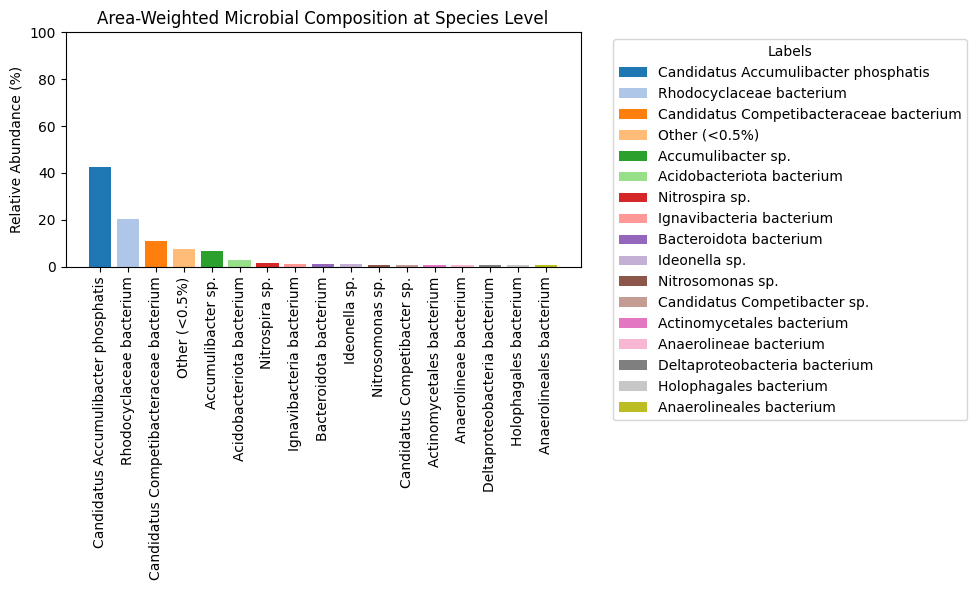

C:\Temp\ipykernel_49348\2641200446.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


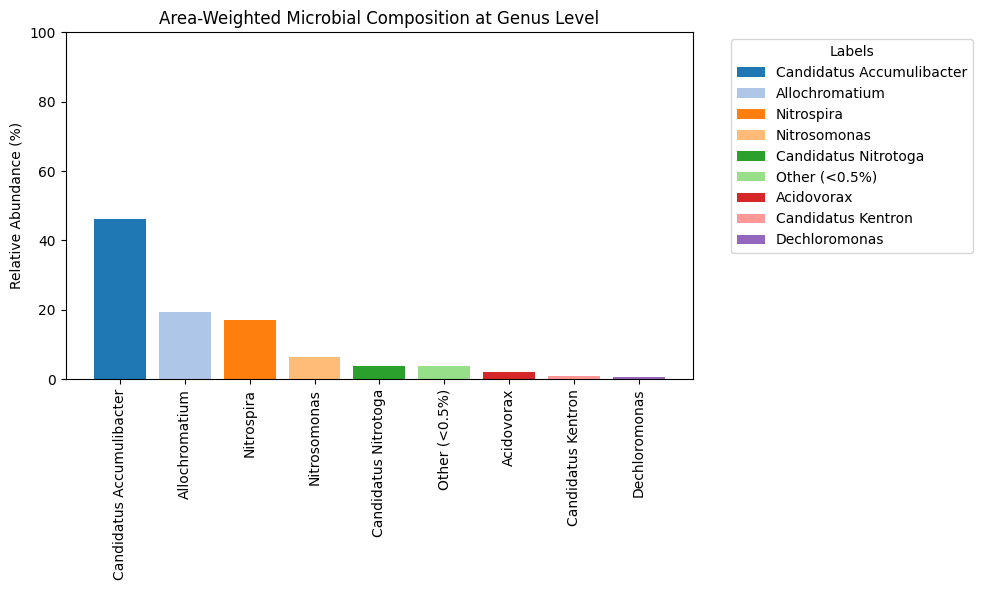

C:\Temp\ipykernel_49348\2641200446.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


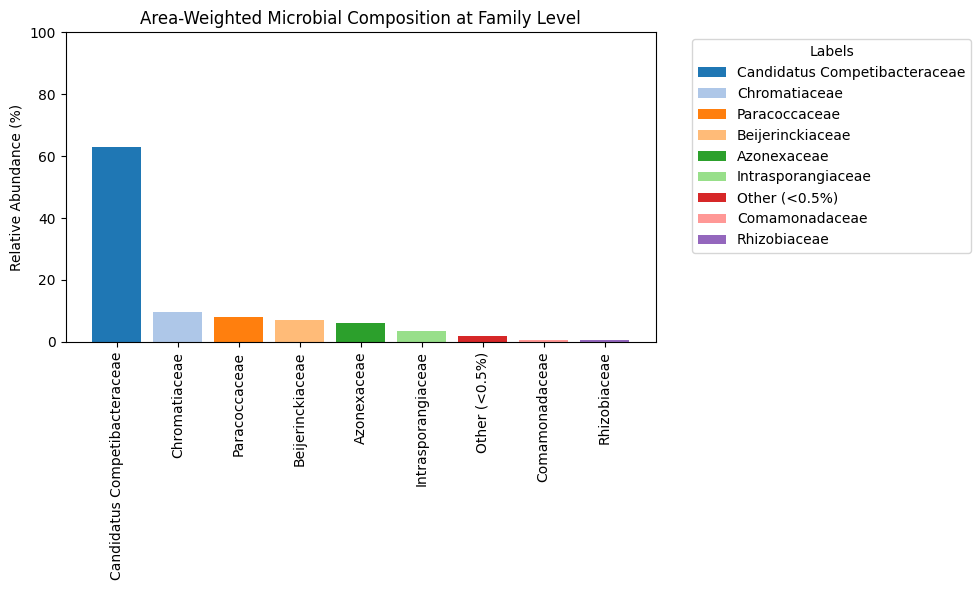

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# === Settings ===
threshold = 0.5  # Taxa below this % abundance will be grouped as "Other"
ranks_to_plot = ["strain", "species", "genus", "family"]  # Rank levels to visualize

# === Loop over each rank and generate area-weighted composition plot ===
for rank in ranks_to_plot:
    # Filter DataFrame to the current rank
    rank_df = df_psm_ranks[df_psm_ranks["taxon_rank"] == rank]

    # Skip if no data or missing intensity
    if rank_df.empty or "Area" not in rank_df.columns:
        print(f"⚠️ No data for rank: {rank}")
        continue

    # === Compute total abundance per taxon ===
    taxon_abundance = rank_df.groupby("taxon_name")["Area"].sum()
    taxon_abundance = taxon_abundance[taxon_abundance > 0]

    # === Convert to relative abundance (%) ===
    rel_abundance = (taxon_abundance / taxon_abundance.sum()) * 100

    # === Split into major taxa and "Other" ===
    main = rel_abundance[rel_abundance >= threshold]
    other = rel_abundance[rel_abundance < threshold]
    if not other.empty:
        main[f"Other (<{threshold}%)"] = other.sum()

    rel_abundance = main.sort_values(ascending=False)

    # === Assign distinct colors ===
    cmap = cm.get_cmap('tab20')
    colors = [cmap(i % cmap.N) for i in range(len(rel_abundance))]

    # === Plotting ===
    plt.figure(figsize=(10, 6))
    bars = plt.bar(rel_abundance.index, rel_abundance.values, color=colors)

    plt.xticks(rotation=90)
    plt.ylabel("Relative Abundance (%)")
    plt.title(f"Area-Weighted Microbial Composition at {rank.title()} Level")
    plt.ylim(0, 100)

    # Optional legend outside plot
    plt.legend(bars, rel_abundance.index, title="Labels", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


## Export Unique Taxa from Metagenomics Database

To evaluate the **coverage** of your custom database relative to the metagenomics database, you first need to extract the **unique taxonomic labels** present in the metagenomics reference.

### Why we do this:
- It gives a **baseline taxonomic composition** of the full metagenomics DB (before PSM filtering).
- By comparing this to the **taxa observed via the custom DB**, you can assess:
  - Which taxa were successfully captured.
  - Which taxa were missed (false negatives).
  - How much overlap exists between the two databases.

### Output:
- A `.csv` file listing each unique taxon (`taxon_name`) and its corresponding `rank` (e.g., genus, species, etc.).


This code saves the unique taxa and their ranks from the raw metagenomics database to a CSV file.

In [ ]:

from pathlib import Path

# Define output path
output_csv_path = base_path / "db_results_analysis" / "unique_taxa_in_metagendb.csv"

# Create DataFrame with unique taxa and their ranks
unique_taxa_df = df_meta_ranks[["taxon_name", "taxon_rank"]].dropna().drop_duplicates().sort_values(by="taxon_name")

# Save to CSV
unique_taxa_df.to_csv(output_csv_path, index=False)

# Confirm
print(f"CSV file saved to: {output_csv_path}")
display(unique_taxa_df.head())


✅ CSV file saved to: c:\Users\Yusuf\OneDrive\LST\Derde_jaar\Y3Q4\Metaproteomics_with_db\db_results_analysis\unique_taxa_in_metagendb.csv


,taxon_name,rank
1021858,ANME-2 cluster archaeon,species
1395692,Abditibacteriaceae,family
278928,Abditibacteriaceae bacterium,species
261471,Abditibacteriota bacterium,species
753005,Abditibacterium utsteinense,species


This code saves the unique taxa and their ranks from the metagenomics psm dataframe to a CSV file.

In [ ]:
# Define output path
output_csv_path = base_path / "db_results_analysis" / "unique_taxa_in_metagenpsmdb.csv"

# Create DataFrame with unique taxa and their ranks
unique_taxa_df = df_psm_ranks[["taxon_name", "taxon_rank"]].dropna().drop_duplicates().sort_values(by="taxon_name")

# Save to CSV
unique_taxa_df.to_csv(output_csv_path, index=False)

# Confirm
print(f"CSV file saved to: {output_csv_path}")
display(unique_taxa_df.head())